In [19]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
from rasterio.windows import from_bounds
from pyproj import transform
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box
import fiona
from rasterio.features import shapes
import osmnx as ox
import os

In [2]:
local_crs = 27700
place = "glasgow"
latlng = (-4.251846930489373, 55.86421405612109)
dist = 30000
country = "united kingdom"
crs=4326

In [ ]:
## create directory ./out/{place} if it does not exist
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
create_dir(f"./output/{place}")

## part 1: Find limits of cells to download

In [3]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
# The distance parameter is half the side length of the square.
# For a 50 km square, the distance will be 25 km.
square = create_square(center_point, 30000)  # 25 km half the side length

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(epsg=crs)

# Plotting
area_of_interest.explore()

In [4]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



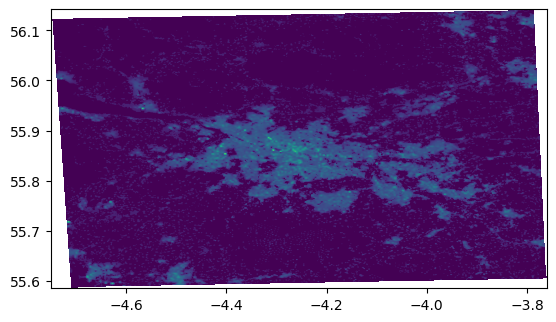

In [5]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [6]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [32]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        with fiona.open(f"output/{place}/height_cells.shp", 'w', 
                        driver='ESRI Shapefile',
                        crs=src.crs,
                        schema=schema) as dst:
            
            # Iterate over each pixel in the raster
            for row in range(image.shape[0]):
                for col in range(image.shape[1]):
                    value = image[row, col]
                    polygon = get_cell_polygon(col, row, transform)
                    dst.write({
                        'properties': {'raster_val': int(value)},
                        'geometry': mapping(polygon)
                    })

DriverIOError: Failed to create file output/glasgow/height_cells.shp: No such file or directory

# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [8]:
area_of_interest = gpd.read_file(f"output/{place}_height_cells.shp")

In [9]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Create a 50 km buffer around the point
buffer = gdf_utm.buffer(30000)  # 30 km buffer

# Reproject buffer back to original CRS
buffer = buffer.to_crs(epsg=crs)

# Plottin
buffer.explore()



In [10]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [11]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [12]:
# selected_features_union.plot()

In [13]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [14]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

/tmp/ipykernel_12407/1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [15]:
buildings.to_parquet('output/building_footprints/glasgow_buildings_50km.pq', index=False)
# buildings = gpd.read_parquet('output/building_footprints/glasgow_buildings_50km.pq')

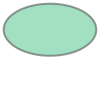

In [16]:
buffer[0]

In [17]:
osm_graph= ox.graph.graph_from_polygon(buffer[0], network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)

streets.head()

osmid  \
u          v           key                                                    
352746     6635138986  0                                          317578232   
6635138986 352772      0    [37679245, 34568014, 34568015, 1782, 317578232]   
352772     249447696   0                                               1783   
           10752209614 0                    [380553603, 380553604, 3469262]   
249447696  10752013398 0                                           23105328   

                            oneway lanes  ref        highway maxspeed  \
u          v           key                                              
352746     6635138986  0      True     4  M74       motorway   70 mph   
6635138986 352772      0      True     4  M74       motorway   70 mph   
352772     249447696   0      True     2  NaN  motorway_link   70 mph   
           10752209614 0      True     2  M74       motorway   70 mph   
249447696  10752013398 0      True     1  M74  motorway_link   70 mph   

                           reversed    length  \
u          v           key                      
352746     6635138986  0      False   366.566   
6635138986 352772      0      False  2984.548   
352772     249447696   0      False   418.927   
           10752209614 0      False  1302.830   
249447696  10752013398 0      False   713.719   

                                                                     geometry  \
u          v           key                                                      
352746     6635138986  0    LINESTRING (271111.552 658992.058, 271031.995 ...   
6635138986 352772      0    LINESTRING (270957.367 659325.226, 270924.496 ...   
352772     249447696   0    LINESTRING (269057.905 661447.208, 268980.982 ...   
           10752209614 0    LINESTRING (269057.905 661447.208, 268984.284 ...   
249447696  10752013398 0    LINESTRING (268687.164 661644.665, 268657.926 ...   

                           bridge name junction access width tunnel est_width  \
u          v           key                                                      
352746     6635138986  0      NaN  NaN      NaN    NaN   NaN    NaN       NaN   
6635138986 352772      0      yes  NaN      NaN    NaN   NaN    NaN       NaN   
352772     249447696   0      NaN  NaN      NaN    NaN   NaN    NaN       NaN   
           10752209614 0      yes  NaN      NaN    NaN   NaN    NaN       NaN   
249447696  10752013398 0      NaN  NaN      NaN    NaN   NaN    NaN       NaN   

                           service  
u          v           key          
352746     6635138986  0       NaN  
6635138986 352772      0       NaN  
352772     249447696   0       NaN  
           10752209614 0       NaN  
249447696  10752013398 0       NaN

In [30]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [31]:
buildings.to_parquet(f"./out/{place}/buildings_raw.pq")

streets.to_parquet(f"./out/{place}/streets_raw.pq")